<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# German News Articles - Data inspection and baseline

Reto Steiner


## Links
- [Ten Thousand German News Articles Dataset](https://tblock.github.io/10kGNAD/)


Der bereitgestellte Code ist ein Python-Notebook, das zur Verarbeitung von deutschen Nachrichtenartikeln und zur Erstellung eines Modells für die Klassifikation von Textdaten verwendet wird. Hier ist eine schrittweise Erläuterung des Codes:

Importieren von Bibliotheken und Installieren von Paketen:

Es werden notwendige Bibliotheken und Pakete wie fhnw-nlp-utils, transformers, pandas, numpy, tensorflow, seaborn und andere importiert oder installiert.
Herunterladen der Daten:

Der Code lädt deutsche Nachrichtenartikeldaten für das Training und die Validierung herunter.
Datenaufbereitung:

Es werden Dateninspektionen durchgeführt, wie das Anzeigen von Datengrößen, das Anzeigen von fehlenden Werten und die Verteilung der Klassen.
Die Textdaten werden bereinigt, um unerwünschte Zeichen und Tags zu entfernen.
Tokenisierung:

Die Textdaten werden mit dem BERT-Tokenisierer in Token umgewandelt.
Daten aufteilen:

Die Daten werden in Trainings- und Testdaten aufgeteilt.
Modell erstellen:

Es wird ein Modell erstellt, das BERT als Vorverarbeitungsschicht verwendet und ein neuronales Netzwerk mit verdeckten Schichten und einer Ausgabeschicht für die Klassifikation hinzufügt.
Modelltraining:

Das Modell wird mit den Trainingsdaten trainiert. Der Optimierer, die Verlustfunktion und andere Parameter werden konfiguriert.
Ein TensorBoard-Callback wird verwendet, um das Training zu überwachen.
Modellbewertung:

Das Modell wird auf den Testdaten bewertet, und Metriken wie Genauigkeit, F1-Score, ROC-AUC, Präzision und Rückruf werden berechnet und angezeigt.
Kommentare und Anmerkungen:

Am Ende des Notebooks gibt es einige Kommentare und Anmerkungen, die nicht spezifiziert sind.
Das Notebook führt also eine komplette Pipeline zur Verarbeitung von Textdaten, zur Modellerstellung und zur Evaluierung des Modells durch. Es verwendet das BERT-Modell als Ausgangspunkt für die Tokenisierung und fügt dann eigene Schichten hinzu, um die Klassifikation durchzuführen. Das Modell wird in TensorBoard überwacht, und am Ende werden verschiedene Metriken angezeigt.

Es ist jedoch nicht möglich, den gesamten Code hier in diesem Format auszuführen. Wenn Sie spezifische Fragen haben oder weitere Informationen zu einem bestimmten Teil des Codes benötigen, stehe ich Ihnen gerne zur Verfügung.

In [1]:
#%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'
!pip install transformers
from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
import pandas as pd
import numpy as np
import re
import tqdm
from datetime import datetime
from transformers import AutoTokenizer, TFAutoModel
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import re
tqdm.tqdm.pandas()
sns.set_style('whitegrid')

pd.options.display.max_colwidth = 600
pd.options.display.max_rows = 400


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f552ee87d4f7fe8b5759c7825b5b0c7be42cf4df6e9fb9eafa25fbd80ca92397
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.1 MB/s eta 0:00:00


In [2]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
data_test = load_dataframe(file)

In [3]:
print(data_train.shape)
print(data_test.shape)

(9245, 2)
(1028, 2)


In [4]:
data_train["split"] = "train"
data_test["split"] = "test"

In [5]:
data_train.head(3)

,text_original,label,split
0,"21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.",Sport,train
1,"Erfundene Bilder zu Filmen, die als verloren gelten: ""The Forbidden Room"" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regisseur Allan Dwan u. a. mit dem Horrordarsteller Lon Chaney ...",Kultur,train
2,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt: Die Wutausbrüche von Apple-Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google-Mitgrü...",Web,train


In [6]:
data_test.head(3)

,text_original,label,split
0,"Die Gewerkschaft GPA-djp lanciert den ""All-in-Rechner"" und findet, dass die Vertragsform auf die Führungsebene beschränkt gehört. Wien – Die Gewerkschaft GPA-djp sieht Handlungsbedarf bei sogenannten All-in-Verträgen. Für mehr Transparenz haben die Gewerkschaft nun unter www.allinrechner.at ein Online-Werkzeug lanciert, das Arbeitnehmern mit solchen Verträgen helfen soll, sich einen Überblick zu verschaffen. Es geht darum, ob die Differenz zum Grundgehalt nicht womöglich eine zu geringe ist. Schließlich sei ein All-in-Gehalt oft nur auf den ersten Blick von Vorteil, gab GPA-djp-Chef Wolfga...",Wirtschaft,test
1,"Franzosen verteidigen 2:1-Führung – Kritische Stimmen zu Schwedens Superstar, Tore in K.-o.-Phase fehlen – Benfica mit Abwehrsorgen nach St. Petersburg. London – Mit einem trügerischen Vorsprung im Gepäck ist Paris Saint Germain zum Champions-League-Achtelfinale nach London gereist. Am Mittwochabend (20.45 Uhr) verteidigt Frankreichs Serienmeister gegen Chelsea ein 2:1 aus dem Hinspiel. PSG sollte gewarnt sein, die Blues sind seit der Trennung von Jose Mourinho erstarkt. Seit Dezember hat Chelsea unter Guus Hiddink in 18 Pflichtspielen nur die eine Niederlage in Paris einstecken müssen. Ei...",Sport,test
2,"Neues Video von Designern macht im Netz die Runde – sie schlagen etwa bunte Benachrichtigungen vor. Bei den iPhone-Verkaufszahlen ist der Wurm drin: Erstmals seit dessen Einführung musste Apple heuer sinkende Quartalsergebnisse bekanntgeben. CEO Tim Cook hat daher versprochen, das im Herbst erscheinende iPhone 7 werde Dinge können, die viele Menschen zu einer Kaufentscheidungen bewegen wird. Ein großer Bestandteil davon ist nicht nur die Hardware, sondern auch das Betriebssystem iOS. Dessen neueste Versionsnummer 10 könnte im Juni bei Apples WWDC-Event präsentiert werden. Noch ist nur weni...",Web,test


In [7]:
data_all = pd.concat([data_train, data_test])
data = data_train

In [8]:
data.head(3)

,text_original,label,split
0,"21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.",Sport,train
1,"Erfundene Bilder zu Filmen, die als verloren gelten: ""The Forbidden Room"" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regisseur Allan Dwan u. a. mit dem Horrordarsteller Lon Chaney ...",Kultur,train
2,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt: Die Wutausbrüche von Apple-Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google-Mitgrü...",Web,train


10273


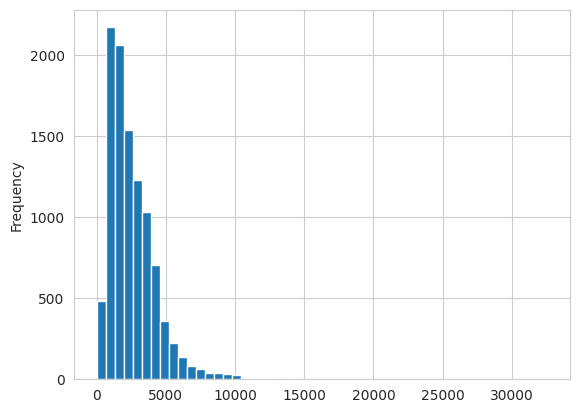

In [9]:
data_all['text_original'].str.len().plot(kind = 'hist', bins = 50)
print(len(data_all))

<Axes: >

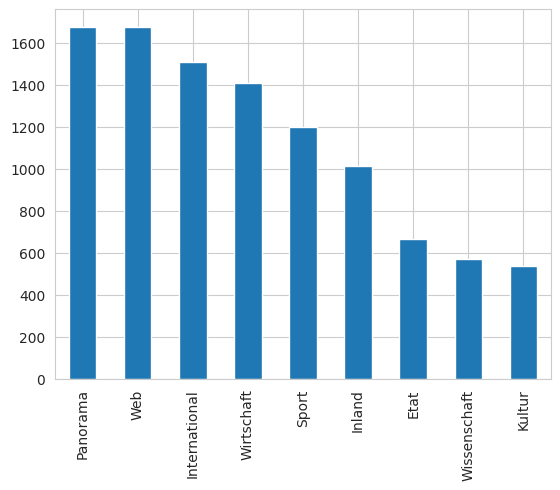

In [10]:
data_all['label'].value_counts().plot(kind = 'bar')

In [11]:
for col in data_all.columns:
    print(f"Missing data for column [{col}]: {data_all[col].isnull().sum()}")

Missing data for column [text_original]: 0
Missing data for column [label]: 0
Missing data for column [split]: 0


In [12]:
df_all = data_all["label"].value_counts().sort_index()
df_train = data_train["label"].value_counts().sort_index()
df_test = data_test["label"].value_counts().sort_index()
df = pd.concat([df_all.to_frame(), df_train.to_frame(), df_test.to_frame()], axis=1)#, keys=["all","train","test"])
df.columns=["all","train","test"]
print (df)

                all  train  test
Etat            668    601    67
Inland         1015    913   102
International  1511   1360   151
Kultur          539    485    54
Panorama       1678   1510   168
Sport          1201   1081   120
Web            1677   1509   168
Wirtschaft     1411   1270   141
Wissenschaft    573    516    57


In [13]:
def clean_text(text, keep_punctuation=False):
    """Cleans text by removing html tags, non ascii chars, digits and optionally punctuation"""



    # Compile RE pattern for HTTPS address, then Substitute it for blank
    RE_HTTPS = re.compile(r"https?://\S+ ")
    text = re.sub(RE_HTTPS, "", text)

    # Subsitute twitter picutures for blank
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)

    # Subsitute multiple points space for 1 point
    text = re.sub(r"\(?[.][.]+\)?", ".", text)

    # Compile RE pattern for HTML tags, then Substitute it for blank
    RE_TAGS = re.compile(r"<[^>]+>")
    text = re.sub(RE_TAGS, " ", text)

    # Compile RE patterns for general text, including punctuation rule
    if keep_punctuation:
        RE_ASCII = re.compile(r"[^a-züöä,.!?]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[a-züöä,.!?]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    # keep only ASCII + European Chars and whitespace, no digits
    text = re.sub(RE_ASCII, " ", text)
    # convert all whitespaces (tabs etc.) to single wspace
    text = re.sub(RE_SINGLECHAR, " ", text)

    # Subsitute multiple blank space for 1 blank space
    text = re.sub(r"\s+", " ", text)

    # Subsitute double punctuation (left-over after previous subsitutions) for 1 point
    text = re.sub(r" [.,]+ [,.]+", ".", text)

    return text

In [14]:
data_all = data_all.drop(["text"], axis=1, errors='ignore')

# Apply text cleaning using MODIN pandas dataframe (parallelized)
data_all["text"] =  data_all["text_original"].apply(clean_text, keep_punctuation = True)

In [15]:
data_all.head(3)

,text_original,label,split,text
0,"21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.",Sport,train,"Jähriger fällt wohl bis Saisonende aus. Wien Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene Jährige erlitt beim Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor."
1,"Erfundene Bilder zu Filmen, die als verloren gelten: ""The Forbidden Room"" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regisseur Allan Dwan u. a. mit dem Horrordarsteller Lon Chaney ...",Kultur,train,"Erfundene Bilder zu Filmen, die als verloren gelten The Forbidden Room von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two Reeler von , den der arbeitswütige US Regisseur Allan Dwan. mit dem Horrordarsteller Lon Chaney gedreht hat. Ein p..."
2,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt: Die Wutausbrüche von Apple-Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google-Mitgrü...",Web,train,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt Die Wutausbrüche von Apple Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google Mitgrün..."


In [16]:
data_all.loc[:,['text','label']]

,text,label
0,"Jähriger fällt wohl bis Saisonende aus. Wien Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene Jährige erlitt beim Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.",Sport
1,"Erfundene Bilder zu Filmen, die als verloren gelten The Forbidden Room von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two Reeler von , den der arbeitswütige US Regisseur Allan Dwan. mit dem Horrordarsteller Lon Chaney gedreht hat. Ein p...",Kultur
2,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt Die Wutausbrüche von Apple Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google Mitgrün...",Web
3,"Putin Einigung, dass wir Menge auf Niveau von Jänner halten . Moskau Die russischen Ölproduzenten wollen nach den Worten von Präsident Wladimir Putin ihre Förderung in diesem Jahr einfrieren. Im Gro en und Ganzen wurde eine Einigung erzielt, dass wir die Ölproduktion auf dem Niveau von Jänner halten werden, sagte Putin am Mittwoch in Moskau. Russland leidet wie andere Förderstaaten unter dem drastischen Einbruch der Ölpreise. Putin will die Preise durch eine begrenzte Förderung im In und Ausland stabilisieren. Dazu hatte Russland jüngst mit Saudi Arabien und anderen gro en Förderländern üb...",Wirtschaft
4,"Estland sieht den künftigen österreichischen Präsidenten auch als estnischen Staatsbürger. Wien Tallinn Pskow Die Eltern des künftigen Bundespräsidenten waren aus dem von Sowjets besetzten Estland in das damalige Deutsche Reich geflohen, wo in Wien Sascha Van der Bellen zur Welt kam. Estnische Verwandte jubelten am Dienstag über dessen Wahlsieg, Freude herrscht auch unter Politikern des Landes. Interesse an Van der Bellen gibt es auch in der russischen Stadt Pskow, der Geburtsstadt seiner Eltern. Wir haben von ganzem Herzen und mit der ganzen Familie mitgefiebert, sagt Irina Steinberg, ein...",Inland
...,...,...
1023,"Programm Ebay Plus soll Ende September starten, aber nur in Deutschland Rückgabemöglichkeit entscheidender Faktor für Onlinekäufer . Bei Ebay können Käufer in Deutschland künftig gegen eine Jahresgebühr auf Portokosten für Rücksendungen verzichten. Wer das Programm Ebay Plus für , Euro im Jahr bucht, bekommt seine Bestellung am nächsten oder spätestens übernächsten Tag und kann die Ware einen Monat lang kostenlos zurücksenden, wie das Unternehmen am Freitag mitteilte. Die Ebay Plus Kunden erhielten zudem Zugang zu exklusiven Deals. Das Programm solle Ende September schrittweise eingeführt ...",Web
1024,"Fehlerhafte Bilanz , Partei will berufen Keine Strafe wegen Wahlkampffinanzierung durch Parlamentsklub. Wien Das BZÖ ist als erste Partei zu einer Geldbu wegen eines unrichtigen Rechenschaftsberichtes verurteilt worden. Weil in der Bilanz für das Jahr keine Angaben zur niederösterreichischen Landespartei gemacht wurden, verhängte der Unabhängige Parteien Transparenz Senat UPTS im Kanzleramt . Euro Strafe. Die Partei will berufen und fehlende Unterlagen nachliefer

In [17]:
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
MAXLEN = 256

def tokenize(data_all):
    encoded = tokenizer.encode_plus(
        text= data_all,
        add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
        max_length=MAXLEN,  # Max length to truncate/pad
        padding='max_length',  # Pad sentence to max length
        return_attention_mask=False,  # attention mask not needed for our task
        return_token_type_ids=False,
        truncation=True, )

    return encoded['input_ids']


In [18]:
data_train = data_all[data_all['split'] == 'train'].loc[:,['text','label']]
data_test = data_all[data_all['split'] == 'test'].loc[:,['text','label']]

In [19]:
input_ids_train = np.array([tokenize(data_train) for data_train in tqdm.tqdm(data_train['text'])])
input_ids_test = np.array([tokenize(data_test) for data_test in tqdm.tqdm(data_test['text'])])

100%|██████████| 1028/1028 [00:08<00:00, 126.94it/s]


In [20]:

label_binarizer = LabelBinarizer()
label_binarizer.fit(data_all["label"])
print(f"Classes: {label_binarizer.classes_}")
print (f"Encoding:\n {label_binarizer.transform(label_binarizer.classes_).T}")

Classes: ['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
Encoding:
 [[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]]


In [21]:
train_ids, test_ids, train_labels, test_labels = input_ids_train, input_ids_test, label_binarizer.transform(data_train['label']),label_binarizer.transform(data_test['label'])

In [22]:
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-5
L2_REG = 1e-3
DROPOUT_RATE = .3

In [23]:
train_dataset = (tf.data.Dataset.from_tensor_slices((train_ids, train_labels))
                    .shuffle(buffer_size=len(train_ids), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))

test_dataset = (tf.data.Dataset.from_tensor_slices((test_ids, test_labels))
                    .batch(BATCH_SIZE))


In [24]:
NUM_CLASSES = len(pd.DataFrame(train_labels).drop_duplicates())
NUM_CLASSES

9

In [25]:
def build_model(max_len=MAXLEN, l2_reg=L2_REG, dropout_rate=DROPOUT_RATE):
    # Eingabeschicht für die Wort-IDs
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )

    # Laden des BERT-Modells
    bert_model = TFBertModel.from_pretrained("bert-base-german-cased")
    encoder_outputs = bert_model(input_word_ids)

    # Extrahieren der letzten versteckten Schicht (last_hidden_state) und des Pooler-Ausgangs (pooler_output) von BERT
    last_hidden_state = encoder_outputs[0]
    pooler_output = encoder_outputs[1]
    cls_embedding = pooler_output
    # Verwendung des Pooler-Ausgangs (cls_embedding) als Eingabe für das folgende neuronale Netzwerk

    # Erstellen einer verdeckten Schicht mit 128 Neuronen und ReLU-Aktivierungsfunktion mit L2-Regularisierung
    hidden = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(cls_embedding)

    # Anwenden der Dropout-Regularisierung auf die verdeckte Schicht
    hidden = tf.keras.layers.Dropout(rate=dropout_rate)(hidden)

    # Erstellen der Ausgabeschicht für die Klassifikation mit Softmax-Aktivierungsfunktion und L2-Regularisierung
    output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(hidden)

    # Zusammenstellen des Modells mit Eingabe und Ausgabe
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)

    return model



In [26]:
model = build_model(max_len=MAXLEN)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 256)]             0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109081344 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 256, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [27]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps= 3*288,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = "categorical_crossentropy"
model.compile(optimizer, loss=loss, metrics=["accuracy"], jit_compile=True)

In [28]:
log_dir = 'logs/' + datetime.now().strftime("%Y%m%d_%H%M%S")
hist = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_dataset,
    steps_per_epoch=int(np.floor((len(input_ids_train) / BATCH_SIZE))),
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="accuracy", verbose=1, patience=3, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    ],
)

Epoch 1/30
288/288 [==============================] - 223s 575ms/step - loss: 1.0755 - accuracy: 0.7296 - val_loss: 0.6001 - val_accuracy: 0.8804
Epoch 2/30
288/288 [==============================] - 145s 504ms/step - loss: 0.5888 - accuracy: 0.8887 - val_loss: 0.5804 - val_accuracy: 0.8920
Epoch 3/30
288/288 [==============================] - 144s 499ms/step - loss: 0.4569 - accuracy: 0.9325 - val_loss: 0.5899 - val_accuracy: 0.9047
Epoch 4/30
288/288 [==============================] - 151s 525ms/step - loss: 0.3903 - accuracy: 0.9552 - val_loss: 0.5828 - val_accuracy: 0.9056
Epoch 5/30
288/288 [==============================] - 146s 507ms/step - loss: 0.3353 - accuracy: 0.9698 - val_loss: 0.6499 - val_accuracy: 0.9018
Epoch 6/30
288/288 [==============================] - 149s 518ms/step - loss: 0.2965 - accuracy: 0.9812 - val_loss: 0.6725 - val_accuracy: 0.9008
Epoch 7/30
288/288 [==============================] - 144s 500ms/step - loss: 0.2812 - accuracy: 0.9858 - val_loss: 0.7166 -

In [29]:
history = pd.DataFrame({'epoch': hist.epoch, **hist.history}).set_index('epoch')
history

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
0,1.075489,0.729601,0.600079,0.880350
1,0.588777,0.888672,0.580444,0.892023
2,0.456947,0.932509,0.589895,0.904669
3,0.390338,0.955187,0.582828,0.905642
4,0.335316,0.969835,0.649944,0.901751
5,0.296534,0.981228,0.672523,0.900778
6,0.281186,0.985786,0.716591,0.886187
7,0.260801,0.991645,0.704039,0.900778
8,0.249732,0.993815,0.765734,0.893969


<Axes: xlabel='epoch'>

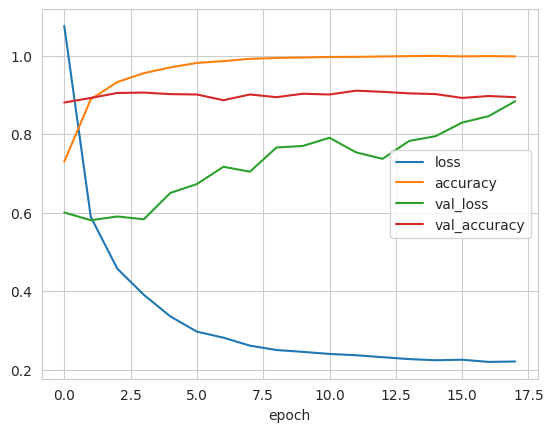

In [30]:
history.plot()

In [31]:
result = model.predict(test_ids)


33/33 [==============================] - 13s 217ms/step


In [32]:
result = result > .5
y_pred = result.astype(int)
y_true = test_labels

In [33]:
l = list(label_binarizer.classes_)

In [34]:

conf = multilabel_confusion_matrix(y_true, y_pred)

conf

array([[[957,   4],
        [  7,  60]],

       [[910,  16],
        [ 18,  84]],

       [[865,  12],
        [ 22, 129]],

       [[967,   7],
        [  6,  48]],

       [[832,  28],
        [ 25, 143]],

       [[907,   1],
        [  0, 120]],

       [[854,   6],
        [  4, 164]],

       [[872,  15],
        [ 15, 126]],

       [[962,   9],
        [  6,  51]]])

In [35]:

"""
f1_score(y_true, y_pred, average='macro')
f1_score(y_true, y_pred, average='micro')
f1_score(y_true, y_pred, average='weighted')
"""
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score ,precision_score, make_scorer, recall_score

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
roc_auc = roc_auc_score(y_true, y_pred)
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

Accuracy: 0.8998054474708171
F1-Score: 0.8985937583587117
ROC-AUC: 0.9427140770523003
Recall: 0.8975533489152997
Precision: 0.9001596267232989


In [36]:
"""
import pickle
from google.colab import drive
drive.mount('/content/drive')

x= {'model' : model, 'result_test' : result, 'LabelBinarizer' : LabelBinarizer};
output = open('/content/drive/MyDrive/CAS DeepLearning/model_NB1.pkl', 'wb')
pickle.dump(x,output)
"""

"\nimport pickle\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nx= {'model' : model, 'result_test' : result, 'LabelBinarizer' : LabelBinarizer};\noutput = open('/content/drive/MyDrive/CAS DeepLearning/model_NB1.pkl', 'wb')\npickle.dump(x,output)\n"